The script for the ratios prediction is given below

In [1]:
# Import the basic libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
import sys
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Set up the path for importing the python codes need
sys.path.extend(['/content/drive/My Drive/cocrystal_design/models',
                 '/content/drive/My Drive/cocrystal_design/notebooks/python_codes' ])

In [4]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache()
#torch.cuda.is_available() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
#from utils.visualization.plot_images_grid import plot_images_grid
import deepSVDD
#from datasets.main import load_dataset
from base.base_net import BaseNet
#from collections import namedtuple

/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/src/set_transformer
/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/src


In [5]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'})

dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0

In [6]:
INPUT_DIM =  1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=10),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
        #self.decoder = nn.Sequential( nn.Linear(in_features=100, out_features=500), nn.LeakyReLU(),
        #nn.Linear(in_features=500, out_features=1000),nn.LeakyReLU(),
        #nn.Linear(in_features=1000, out_features=1857),nn.LeakyReLU(),         
        #nn.Linear(in_features=1857, out_features=3714), nn.Sigmoid())

        self.decoder.apply(init_weights)


## nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [7]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()
    #return nn.Sequential()~

def build_network(net_name):
  
  return PairsEncoder()
    #return nn.Sequential()
torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [8]:
# Load the deep learning model
torch.manual_seed(0)

deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
#net_name='model_checkpoint.pth'
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
deep_SVDD.load_model('/content/drive/My Drive/cocrystal_design-master/models/deep_one_class/model_checkpoint_60_epochs.pth')

In [9]:
# Import the datasets

dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers2.csv')
dataset1.head()

# Dataset with ratios
dictionar=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/cocrystal_ratios.csv')
keys = dictionar.iloc[:, 0].values
values = dictionar.iloc[:, 3:7].values
d = {key:value for key, value in zip(keys, values)}

In [10]:
# Assign to each combination their molecular ratio and their Z number
ratios=[]
for x in dataset2['Identifier'].values:
  ratios.append(d[x])  
ratio=pd.DataFrame(ratios, columns=['Z', 'mol1', 'mol2', 'ratios'])  
rat=pd.concat([dataset2 ,ratio], axis=1)
dataset = rat.drop(['mol1', 'mol2'], axis=1)
d2=dataset.drop(['Identifier', 'NAME'], axis=1)
d1= dataset1.insert(loc=2, column='NAME2', value=dataset['NAME'])
dataset_ratios=pd.concat([dataset1, d2], axis=1)


In [11]:
df1=dataset1.iloc[:,3:]
df1 = df1.fillna(df1.mean())
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(df2.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]


In [12]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict= {key:value for key, value in zip(k1, v1)}
print(dict['comb1'])

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [13]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset1, dataset2):

  return pd.concat([pd.concat([dataset['Identifier'], dataset1, dataset2], axis=1), pd.concat([dataset['Identifier'].apply(lambda x: f"{x}_"),dataset2, dataset1], axis=1) ])


In [14]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
#X_scaler = StandardScaler()

df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df_ratios = pd.concat([df, pd.concat([dataset['ratios'], dataset['ratios']])], axis=1)
df_ratios.tail()

,Identifier,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,nAT,nSK,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nHM,nHet,nX,H%,C%,N%,O%,X%,nCsp3,...,Hy,AMR,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,ALOGP,ALOGP2,SAtot,SAacc,Vx,VvdwMG,VvdwZAZ,PDI,BLTF96,BLTD48,BLTA96,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_cons,LLS_01,LLS_02,CMC-80,CMC-50,Inflammat-80,Inflammat-50,Depressant-80,Psychotic-80,Hypertens-80,Hypnotic-80,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50,ratios
1717,AFOTIB_,0.007336,0.048022,0.009960,0.010702,0.010247,0.013163,0.213913,0.218182,0.142678,0.394052,0.013369,0.010695,0.015345,0.009217,0.034483,0.016447,0.0,0.0,0.0,0.0,0.034483,0.038095,0.026316,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.761429,0.585652,0.00000,0.0,0.0,0.010417,...,0.040886,0.371591,0.213870,0.121965,0.585153,0.077114,0.405911,0.128157,0.159532,0.174018,0.408174,0.408174,0.339226,0.365471,0.581612,0.581522,0.581756,0.0,0.333333,0.00000,0.253731,0.4,0.5,0.39759,0.341176,0.00000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1/3
1718,CIQNIC_,0.007336,0.048022,0.009960,0.010702,0.010247,0.013163,0.213913,0.218182,0.142678,0.394052,0.013369,0.010695,0.015345,0.009217,0.034483,0.016447,0.0,0.0,0.0,0.0,0.034483,0.038095,0.026316,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.761429,0.585652,0.00000,0.0,0.0,0.010417,...,0.071550,0.276064,0.000000,0.000000,0.702168,0.231790,0.656899,0.395933,0.159532,0.174018,0.475339,0.475339,0.446229,0.365471,0.417578,0.417391,0.417556,0.0,0.333333,0.00000,0.253731,0.5,0.5,0.39759,0.352941,0.39759,0.173333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1/2
1719,DIVZUG_,0.007336,0.048022,0.009960,0.010702,0.010247,0.013163,0.213913,0.218182,0.142678,0.394052,0.013369,0.010695,0.015345,0.009217,0.034483,0.016447,0.0,0.0,0.0,0.0,0.034483,0.038095,0.026316,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.761429,0.585652,0.00000,0.0,0.0,0.010417,...,0.059341,0.447941,0.635763,0.574191,0.553179,0.049300,0.502026,0.213310,0.407073,0.502437,0.457477,0.457477,0.383055,0.424242,0.626569,0.626449,0.626506,0.0,0.000000,0.00000,0.000000,0.5,0.5,0.00000,0.141176,0.00000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1/2
1720,PIQTOB_,0.007336,0.048022,0.009960,0.010702,0.010247,0.013163,0.213913,0.218182,0.142678,0.394052,0.013369,0.010695,0.015345,0.009217,0.034483,0.016447,0.0,0.0,0.0,0.0,0.034483,0.038095,0.026316,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.761429,0.585652,0.00000,0.0,0.0,0.010417,...,0.063316,0.185462,0.000000,0.000000,0.438005,0.000463,0.241250,0.053311,0.159532,0.174018,0.092767,0.092767,0.086713,0.365471,0.787768,0.787681,0.787952,1.0,1.000000,1.00000,1.000000,0.9,0.5,1.00000,0.894118,0.60241,1.000000,0.147579,0.030746,0.064566,0.013067,0.042275,0.040738,0.075327,0.05073,0.111453,0.029208,0.193697,0.033051,1/2
1721,RAWXEU_,0.002560,0.075504,0.001103,0.000629,0.000117,0.002792,0.276522,0.275758,0.160200,0.431227,0.002674,0.005348,0.005115,0.004608,0.034483,0.013158,0.0,0.0,0.0,0.0,0.034483,0.023810,0.015789,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.650000,0.568082,0.15937,0.0,0.0,0.000000,...,0.086882,0.127527,0.218010,0.124326,0.568527,0.061880,0.214677,0.022901,0.114399,0.213824,0.125908,0.125907,0.104198,0.350000,0.604698,0.604710,0.604819,0.0,0.333333,0.60241,0.507463,0.2,0.0,0.60241,0.447059,0.00000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1/2


In [15]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [16]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()

lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])


1722


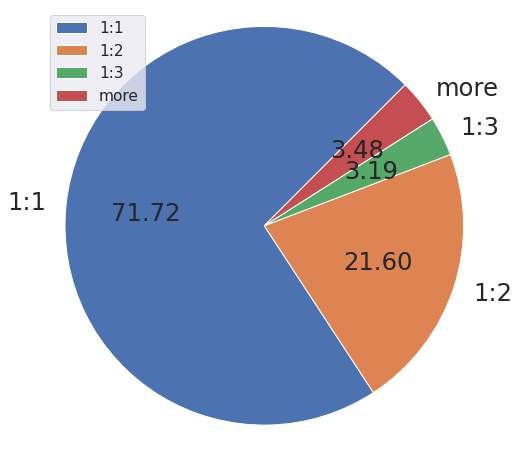

In [184]:
# Count the molecular ratios of the co-crystals in the training set and visualization in a pie chart

import matplotlib.pyplot as plotter
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

counts = dataset_ratios.ratios.value_counts() #dataset_ratios.ratios.value_counts()
# The slice names of a population distribution pie chart
pieLabels = '1:1', '1:2', '1:3', 'more'

# Population data
populationShare  = (counts.values[0], counts.values[1], counts.values[2], dataset_ratios.shape[0]-counts.values[0] -counts.values[1]- counts.values[2])
figureObject, axesObject = plotter.subplots()

# Draw the pie chart
axesObject.pie(populationShare, labels=pieLabels,  autopct='%1.2f', startangle=45,  textprops={'size': 'x-large'}, radius=0.5)
axesObject.axis('equal')
plotter.figure
plotter.legend()
#plotter.savefig('pie-chart.eps')
plotter.show()

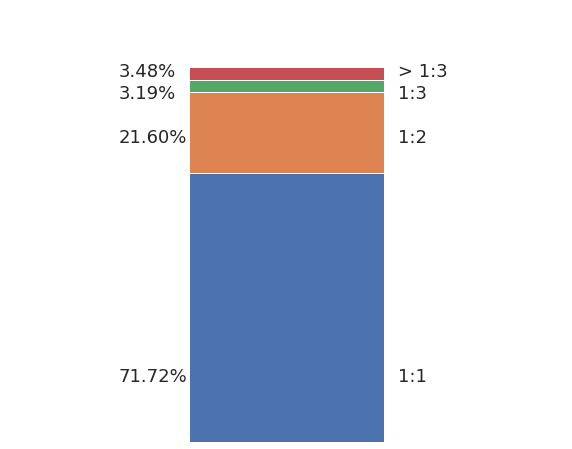

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

Labels = '1:1', '1:2', '1:3', 'more'
df1 = pd.concat([pd.DataFrame(Labels, columns=['ratio']) ,pd.DataFrame(populationShare, columns=['count'])], axis=1)
freq = pd.Series(df1['count'])
fig,ax = plt.subplots(figsize=(10,8))
fig.patch.set_visible(False)
ax.axis('off')
freq.to_frame().T.plot.bar(stacked=True, width=0.07, ax=ax)
ax.get_legend().remove()
ax.text(0.04, 300, s='1:1', va='center', fontsize=18)
ax.text(0.04, 1400, s='1:2', va='center', fontsize=18)
ax.text(0.04, 1600, s='1:3', va='center', fontsize=18)
ax.text(0.04, 1700, s='> 1:3', va='center', fontsize=18)

# Add the percentages
ax.text(-0.06, 300, s='71.72%', va='center', fontsize=18)
ax.text(-0.06, 1400, s='21.60%', va='center', fontsize=18)
ax.text(-0.06, 1600, s='3.19%', va='center', fontsize=18)
ax.text(-0.06, 1700, s='3.48%', va='center', fontsize=18)
ax.set_ylabel('Counts')
ax.set_xlabel('Co-crystal Ratios')
ax.set_ylim(0, 2000)
ax.set_xlim(-0.1, 0.1)

plt.savefig('barch.svg')

In [18]:
ratios = df_ratios.ratios
ratios[ratios != '1'] = 1
ratios[ratios == '1'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [178]:
# Predict the ratios
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

net = deep_SVDD.net.to(device)
X= df.iloc[:,1:].values

X = torch.FloatTensor(X).to(device)
y1 = net(X)

X= y1.cpu().detach().numpy()


y= ratios# df_ratios.iloc[:, -1].values #

y = y.apply(str)


In [179]:
from imblearn.over_sampling import SMOTE

smote =SMOTE('minority', k_neighbors=5, random_state=0)

X_sm, y_sm= smote.fit_sample(X, y)
print(X_sm.shape, y_sm.shape)
print(X.shape)


X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.35, random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(4940, 100) (4940,)
(3444, 100)


In [171]:
# Same settings but having as an input the bidirectional representation
clf = XGBClassifier(learning_rate=0.2, n_estimators=40, max_depth=10,
                        min_child_weight=1, gamma=0.01, subsample=0.9, colsample_bytree=0.53,
                        objective='binary:logistic', nthread=2, scale_pos_weight=1, seed=0) 
eval_set = [(X_train, y_train), (X_test, y_test)]

clf.fit(X_train, y_train, early_stopping_rounds=15, eval_metric="auc", eval_set=eval_set, verbose=True)
y_pred = clf.predict(X_test)                     


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[0]	validation_0-auc:0.875305	validation_1-auc:0.690772
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.960516	validation_1-auc:0.742098
[2]	validation_0-auc:0.981817	validation_1-auc:0.769991
[3]	validation_0-auc:0.989518	validation_1-auc:0.794058
[4]	validation_0-auc:0.991876	validation_1-auc:0.805466
[5]	validation_0-auc:0.995101	validation_1-auc:0.824768
[6]	validation_0-auc:0.997317	validation_1-auc:0.831946
[7]	validation_0-auc:0.997385	validation_1-auc:0.834819
[8]	validation_0-auc:0.998242	validation_1-auc:0.839298
[9]	validation_0-auc:0.998889	validation_1-auc:0.846132
[10]	validation_0-auc:0.999026	validation_1-auc:0.848025
[11]	validation_0-auc:0.999495	validation_1-auc:0.852016
[12]	validation_0-auc:0.999665	validation_1-auc:0.853135
[13]	validation_0-auc:0.999745	validation_1-auc:0.855778
[14]	validation_0-auc:0.999825	validation_1-auc:0.85629

In [172]:
labels = np.arange(2)
target_names = ['1:1', '>1:1']
clf_report = classification_report(y_test, y_pred,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


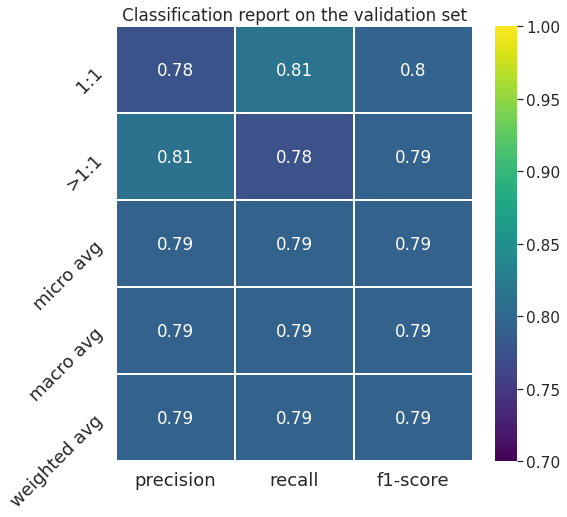

In [174]:
import seaborn as sns
sns.set(font_scale=1.4)

res=sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='viridis',  linewidths=1, vmin=0.7, vmax=1 )
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18, rotation=45)
plt.title('Classification report on the validation set')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures_SI/seaborn_clf_report2.svg',  rasterized=True,  bbox_inches="tight", dpi=600)

In [180]:
clf = XGBClassifier(learning_rate=0.2, n_estimators=30, max_depth=10,
                        min_child_weight=1, gamma=0.01, subsample=0.9, colsample_bytree=0.53,
                        objective='binary:logistic', nthread=2, scale_pos_weight=1, seed=0) 
eval_set = [(X_train, y_train), (X_test, y_test)]

clf.fit(X_train, y_train, early_stopping_rounds=15, eval_metric="auc", eval_set=eval_set, verbose=True)
y_pred = clf.predict(X_test)                     


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[0]	validation_0-auc:0.925763	validation_1-auc:0.818761
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.972836	validation_1-auc:0.873807
[2]	validation_0-auc:0.989917	validation_1-auc:0.903984
[3]	validation_0-auc:0.993541	validation_1-auc:0.923453
[4]	validation_0-auc:0.996191	validation_1-auc:0.934123
[5]	validation_0-auc:0.997902	validation_1-auc:0.943302
[6]	validation_0-auc:0.998982	validation_1-auc:0.954545
[7]	validation_0-auc:0.999269	validation_1-auc:0.961542
[8]	validation_0-auc:0.999319	validation_1-auc:0.964849
[9]	validation_0-auc:0.999364	validation_1-auc:0.966956
[10]	validation_0-auc:0.999418	validation_1-auc:0.970519
[11]	validation_0-auc:0.999639	validation_1-auc:0.973291
[12]	validation_0-auc:0.999833	validation_1-auc:0.974281
[13]	validation_0-auc:0.999932	validation_1-auc:0.976052
[14]	validation_0-auc:0.999976	validation_1-auc:0.97729

In [181]:
labels = np.arange(2)
target_names = ['1:1', '>1:1']
clf_report = classification_report(y_test, y_pred,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


[Text(0.5, 0, 'precision'), Text(1.5, 0, 'recall'), Text(2.5, 0, 'f1-score')]

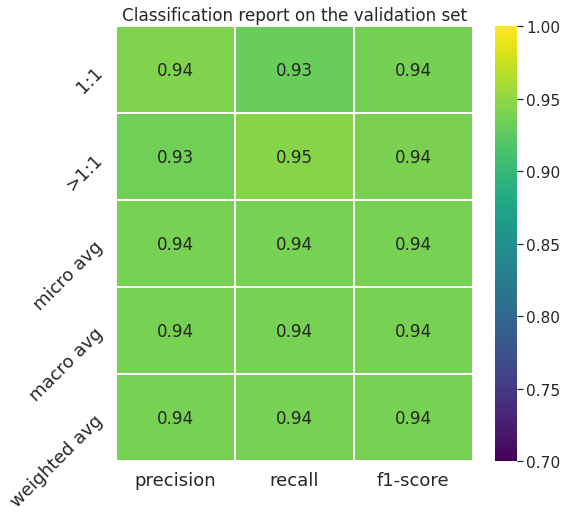

In [183]:
import seaborn as sns
sns.set(font_scale=1.4)

res=sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='viridis',  linewidths=1, vmin=0.7, vmax=1 )
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18, rotation=45)
plt.title('Classification report on the validation set')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures_SI/seaborn_clf_report1.svg',  rasterized=True,  bbox_inches="tight", dpi=600)

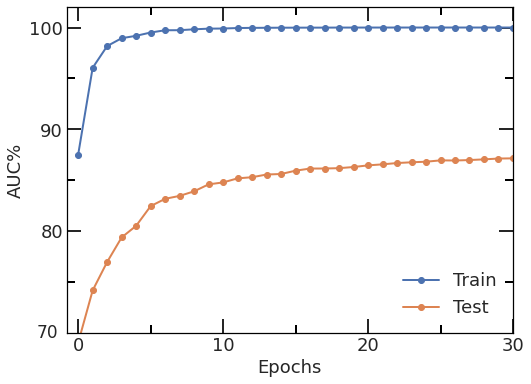

In [176]:
# Plot the most important features 
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib import rcParams
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

results = clf.evals_result()
x_axis = range(0, 40)
fig, ax = plt.subplots(figsize=(8,6))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.set_xlim(-0.8, 30)
ax.set_ylim(70, 102)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 31, 10)
minor_ticks_x = np.arange(0,31, 5)
major_ticks_y = np.arange(70, 101, 10)
minor_ticks_y = np.arange(70, 101, 5)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

ax.plot(x_axis, np.array(results['validation_0']['auc'])*100, label='Train', linewidth=2, marker='o')
ax.plot(x_axis, np.array(results['validation_1']['auc'])*100, label='Test', linewidth=2, marker='o')
ax.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax.text(-0.066, -0.015, '70', transform=ax.transAxes, fontsize= 17)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18, loc="lower right", framealpha=0)

#ax.set_ylim([0.74, 1.01])
plt.ylabel('AUC%', fontsize=18)
plt.xlabel('Epochs', fontsize=18 )
#plt.title('XGBoost AUC (Bidirectional Representation)', fontsiz~e=18)
plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures_SI/AUC_no_Setr.svg')

In [95]:
# Import the scalled unlabelled dataset 
uf_final = pd.read_pickle('/content/drive/My Drive/cocrystal_design-master/data/unlabelled_all_new.pkl')

In [130]:
# Import the scored assigned from the deep model to select the top quantile of the scored unlabelled data
deep_scores= pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/deep_scores_60_epochs.csv')
deep_unlab = deep_scores.iloc[1722:, :]
top=pd.concat([uf_final.Identifier ,pd.DataFrame(deep_unlab.score.values, columns=['score'])], axis=1)

c=pd.DataFrame(top.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = top.sort_values(by = ['score'], ascending=True)
b = top[top['score'] > c]
pred1 = uf_final[uf_final.Identifier.isin(b.Identifier)]

In [146]:
# Use the network to score the predicted inliers

net = deep_SVDD.net.to(device)
pred1=pred1.fillna(0)
X_pred= pred1.iloc[:,1:].values
X_pred = torch.FloatTensor(X_pred).to(device)
y_pred = net(X_pred)
X_pred= y_pred.cpu().detach().numpy()
k=clf.predict(X_pred)

In [147]:
# Predict the ratios of the experimental co-crystals
pred_ratios = pd.concat([pd.DataFrame(pred1.Identifier.values, columns=['Identifier']), pd.DataFrame(k, columns=['ratio'])], axis=1)
experimental = ['comb1799', 'comb1817']
exp_pred_ratios = pred_ratios[pred_ratios.Identifier.isin(experimental)]
smiles = []
for i in exp_pred_ratios.Identifier.values:
  smiles.append('.'.join(dict[i]))
exp_pred_ratios = pd.concat([pd.DataFrame(exp_pred_ratios.values, columns=exp_pred_ratios.columns.values), pd.DataFrame(smiles, columns=['smiles'])], axis=1)
exp_pred_ratios

,Identifier,ratio,smiles
0,comb1799,1,c1cc2ccc3cccc4ccc(c1)c2c34.O=C1Oc2ccccc2c3ccccc13
1,comb1817,0,c1cc2ccc3cccc4ccc(c1)c2c34.N#Cc1c2ccccc2c(C#N)...


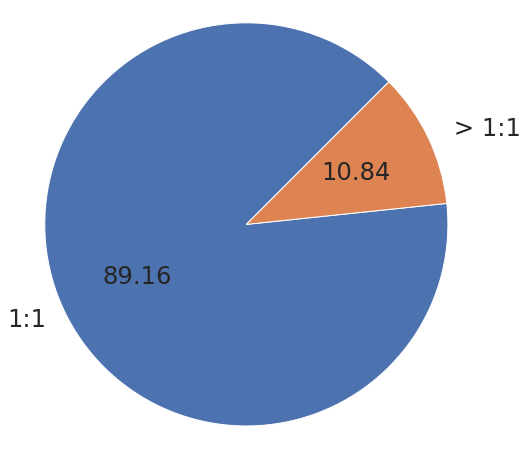

In [149]:
# Count the molecular ratios of the co-crystals in the training set and visualization in a pie chart

import matplotlib.pyplot as plotter
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

unlab_ratios = pd.DataFrame(k, columns=['ratio'])
counts = unlab_ratios.ratio.value_counts()

# The slice names of a population distribution pie chart
pieLabels = '1:1', ' > 1:1'

# Population data
populationShare  = populationShare  = (counts[0], counts[1])
figureObject, axesObject = plotter.subplots()

# Draw the pie chart
axesObject.pie(populationShare, labels=pieLabels,  autopct='%1.2f', startangle=45,  textprops={'size': 'x-large'}, radius=0.5)
axesObject.axis('equal')
plotter.figure
#plotter.legend()
#plotter.savefig('pie-chart_un.svg')
plotter.show()